In [1]:
import os
import sys
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.config.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.datasets.formatters import *
%matplotlib inline

In [5]:
NUM_PROC = 8
DATASET_CONFIG = BaseDatasetConfig(
    name="ai4b", meta_file_train="metadata.csv", path="/home/gokulkarthikk/datasets/indictts/ta",
    language='ta'
)

In [6]:
def formatter_ai4b(root_path, meta_file, **kwargs):  # pylint: disable=unused-argument
    txt_file = os.path.join(root_path, meta_file)
    items = []
    with open(txt_file, "r", encoding="utf-8") as ttf:
        for line in ttf:
            cols = line.split("|")
            wav_file = os.path.join(root_path, "wavs", cols[0] + ".wav")
            text = cols[1].strip()
            speaker_name = cols[2].strip()
            items.append({"text": text, "audio_file": wav_file, "speaker_name": speaker_name})
    return items

In [7]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
train_samples, eval_samples = load_tts_samples(DATASET_CONFIG, eval_split=True, formatter=formatter_ai4b)
items = train_samples + eval_samples
print(" > Number of audio files: {}".format(len(items)))
print(items[1])

 | > Found 6960 files in /home/gokulkarthikk/datasets/indictts/ta
 > Number of audio files: 6960
{'text': 'ஊர்வலத்தின் முன்னணியில் ஒரு யானை தன் தும்பிக்கையில் மாலை ஏந்தி நடந்து வந்து கொண்டிருந்தது.', 'audio_file': '/home/gokulkarthikk/datasets/indictts/ta/wavs/train_tamilmale_02356.wav', 'speaker_name': 'male', 'language': 'ta'}


In [8]:
print(len(train_samples), len(eval_samples))

6891 69


In [9]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item['audio_file'].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(wav_file)

In [10]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [11]:
item

{'text': 'சுந்தர சோழருக்கு முன்னால், அரசு புரிந்த கண்டராதித்தர், சிவபக்தியில் திளைத்து, சிவஞான கண்டராதித்தர் என்று புகழ் பெற்றவர்.',
 'audio_file': '/home/gokulkarthikk/datasets/indictts/ta/wavs/train_tamilfemale_01045.wav',
 'speaker_name': 'female',
 'language': 'ta'}

In [12]:
def load_item(item):
    text = item['text'].strip()
    file_name = item['audio_file'].strip()
    audio, sr = librosa.load(file_name, sr=None)
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

100%|██████████| 6960/6960 [02:58<00:00, 39.04it/s]


In [13]:
data[0]

('/home/gokulkarthikk/datasets/indictts/ta/wavs/train_tamilmale_03163.wav',
 'பில்லியன் மக்களை தன்னகத்தே கொண்ட சாதிய சமுதாய அமைப்புகளின் மருபணு இயற்கையை அறிய மாதிரிகளைக் கொண்ட ஒரு ஆய்வு எவ்வளவு உதவ முடியும் சில சாதி பிரிவுகளின் மாதிரி அளவு வெறும் இந்திய புள்ளியியல் நிறுவனத்தைச் சார்ந்த மஜும்தார் இவ்வாராய்வின் இத்தகைய பல தவறான போக்குகளை சுட்டிக்காட்டியுள்ளார்.',
 283,
 array([-3.0517578e-05,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  6.1035156e-05, -1.2207031e-04], dtype=float32),
 20.5855625)

In [14]:
durs = [item[-1] for item in data]
print(sum(durs)/(60*60))

20.590784531250023


In [13]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|██████████| 6960/6960 [00:00<00:00, 171093.74it/s]

 > Number of words: 37080


In [14]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

100%|██████████| 6960/6960 [00:00<00:00, 613800.59it/s]


In [15]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [16]:
for item in data:
    if item[-1] <= 1:
        print(item)

In [17]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [18]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.08241033481853367
0.011320645779761917


In [19]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        #print(item)
        pass

### Plot Dataset Statistics

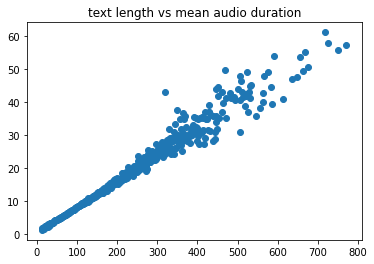

In [20]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

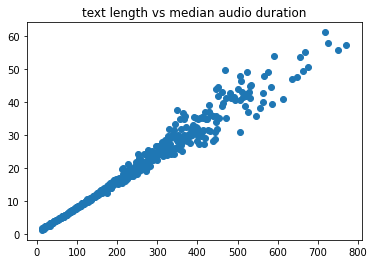

In [21]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

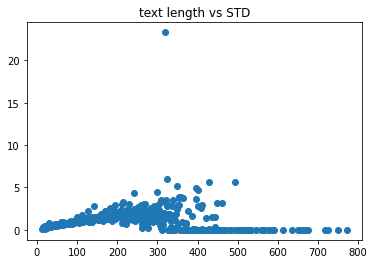

In [22]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

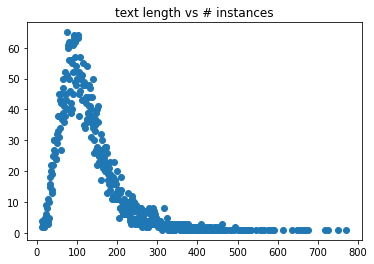

In [23]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

100%|██████████| 6960/6960 [00:00<00:00, 1778070.16it/s]


Text(0.5, 1.0, 'audio length distribution')

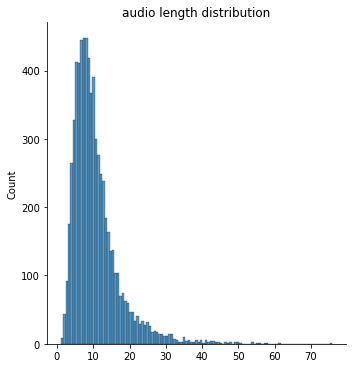

In [24]:
audio_lens = []
for item in tqdm(data):
    audio_len = item[-1]
    audio_lens.append(audio_len)

sns.displot(audio_lens)
plt.title("audio length distribution")

### Check words frequencies

In [25]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [26]:
w_count_df

,0
என்று,1068
ஒரு,906
நான்,449
அந்த,397
இந்த,381
...,...
"ஊற்றுகளில்,",1
அம்மம்மா,1
பயங்கரப்படுத்தியது,1
"கடகடா,",1


In [28]:
# check a certain word
w_count_df.at['நான்', 0]

449

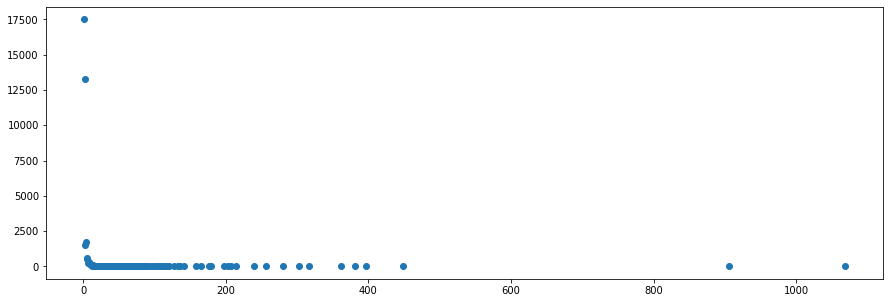

In [29]:
w_count_counter = Counter(w_count.values())
plt.figure(figsize=(15,5))
plt.scatter(list(w_count_counter.keys()), list(w_count_counter.values()))

<Figure size 432x288 with 0 Axes>

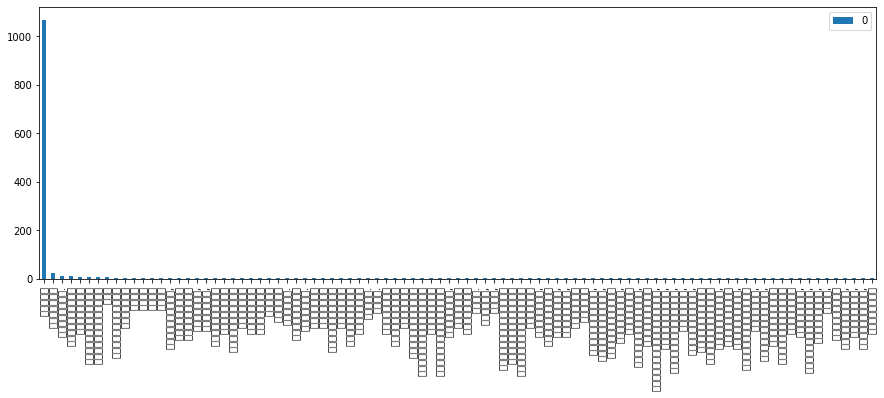

In [59]:
# fequency bar plot - samples
import matplotlib as mpl
plt.figure()
#plt.rcParams.update({'font.family': 'Vijaya'}) 
mpl.rcParams['font.sans-serif'] = ['Source Han Sans TW',
                                   'sans-serif',
                                   "Arial Unicode MS"  # fc-list :lang=hi family
                                   ]
#plt.rc('font', family='Vijaya')
ax = w_count_df.iloc[::400].plot.bar(figsize=(15,5))
plt.show()

/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2962 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2959 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2962 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2959 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg

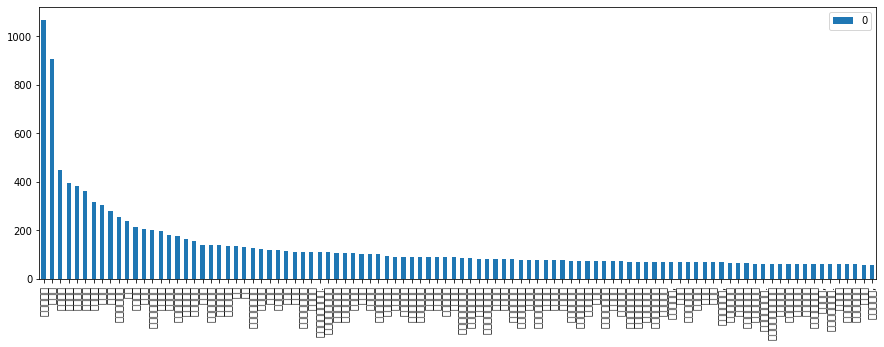

In [60]:
# fequency bar plot - first 100
w_count_df.iloc[:100].plot.bar(figsize=(15,5))

/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2947 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2954 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2947 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/gokul_kumar/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2954 missing from current font.
  font.set_text(s, 0, flags=flags)


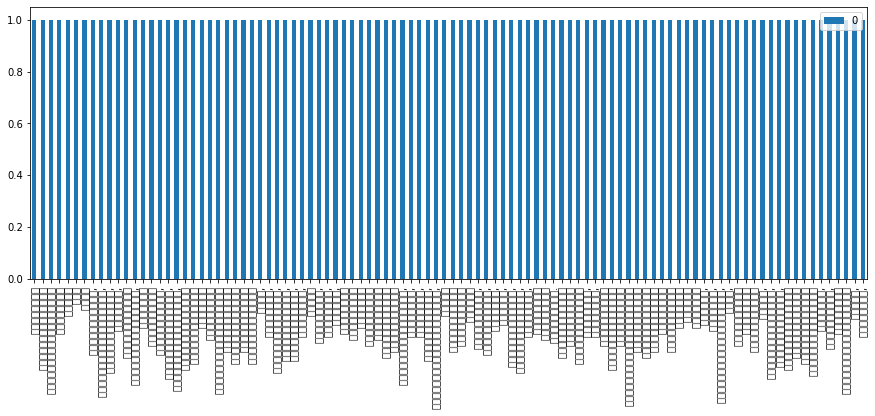

In [61]:
# fequency bar plot - tlastop 100
w_count_df.iloc[-100:].plot.bar(figsize=(15,5))